In [ ]:
# Install FluidSynth: a real-time software synthesizer based on the SoundFont 2 specifications.
# It's used to convert MIDI data into audio that can be played or further processed.
# The '-y' option automatically agrees to the installation, avoiding the need for manual confirmation.
!sudo apt install -y fluidsynth
# Upgrade and install pyfluidsynth: a Python binding for FluidSynth, enabling Python scripts to interact with the FluidSynth library.
# This allows for synthesizing audio from MIDI data directly within Python, suitable for dynamic music generation and manipulation tasks.
!pip install --upgrade pyfluidsynth
# Install pretty_midi: a Python library for analyzing and editing MIDI files.
# It provides simple and intuitive functions to work with MIDI data, making it ideal for tasks like music information retrieval, composition, and data-driven music analysis.
!pip install pretty_midi


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
import collections  # Provides specialized container datatypes, such as defaultdict and OrderedDict, which offer additional functionality compared to Python's built-in containers like dict, list, set, and tuple.

import fluidsynth  # Allows for real-time synthesis of MIDI data into audio using the FluidSynth software synthesizer, enabling audio generation and manipulation within Python.

import glob  # Helps with file path pattern matching, allowing for searching and listing files in a directory that match a specified pattern, useful for batch processing files.

import numpy as np  # A fundamental package for scientific computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

import pathlib  # Offers object-oriented filesystem paths, providing a simple way to interact with file system paths, making file manipulation tasks more intuitive and portable across operating systems.

import pandas as pd  # A powerful data manipulation and analysis library, providing data structures like DataFrame and Series for handling and analyzing structured data.

import pretty_midi  # A library for analyzing and manipulating MIDI files, enabling tasks such as parsing MIDI files, extracting musical information, and creating new MIDI files programmatically.

import seaborn as sns  # A statistical data visualization library based on matplotlib, providing a high-level interface for drawing attractive and informative statistical graphics.

import tensorflow as tf  # An end-to-end open-source machine learning platform, widely used for building and training neural networks for deep learning tasks.

from matplotlib import pyplot as plt  # A plotting library and its object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK.

from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense  # Keras layers used for building neural network models: Input for specifying the shape/dimensions of the input data, Bidirectional for wrapping RNN layers (e.g., LSTM) to make them bidirectional, LSTM for Long Short-Term Memory layers, and Dense for fully connected neural network layers.

from tensorflow.keras.models import Model  # The basic class in Keras for constructing neural network models, providing functionality to build and train models.

from IPython import display  # Provides display tools for IPython environments (like Jupyter notebooks), enabling rich media representations of objects (e.g., displaying images or videos within the notebook).


##1. Data Preparation

###1.1 Download and Inspect Data

In [ ]:
seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)

_SAMPLING_RATE = 16000


In [ ]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v3.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )

filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(f'Number of files: {len(filenames)}')
'''
This section of the code is responsible for setting up the dataset for our project, which in this case is the MAESTRO (MIDI and Audio Edited for Synchronous TRacks and Organization) v3.0.0 dataset. This dataset is a collection of MIDI files recorded from live piano performances. The steps performed in this section include:

1. Define the directory where the dataset will be stored. This is done by specifying a path ('data/maestro-v3.0.0') using the `pathlib.Path` function. The `pathlib` module is used for object-oriented file system path handling.

2. Check if the dataset directory already exists. If it does not, the dataset is downloaded and extracted:
    - The `tf.keras.utils.get_file` function is used to download the dataset from the specified URL. This function also has the capability to extract the downloaded file if it is an archive (like a ZIP file).
    - The 'origin' parameter specifies the URL where the dataset can be found. For the MAESTRO dataset, this URL points to a ZIP file hosted on Google Cloud Storage.
    - The 'extract' parameter is set to `True`, indicating that the downloaded ZIP file should be automatically extracted.
    - The 'cache_dir' and 'cache_subdir' parameters specify the directory where the downloaded and extracted files should be stored. In this case, they are stored in the 'data' subdirectory within the current working directory.

3. After ensuring the dataset is downloaded and extracted, the code then creates a list of all MIDI file paths in the dataset. This is achieved using the `glob.glob` function, which returns a list of paths matching a specified pattern. In this case, the pattern is set to include all files in the dataset directory (and its subdirectories) that have a '.mid' or '.midi' extension. This is important for processing or analyzing the MIDI files in subsequent steps.

4. Finally, the number of MIDI files found is printed out. This serves as a simple check to ensure that the files were successfully located and can be used for further processing.
'''

58416533/58416533 [==============================] - 0s 0us/step
Number of files: 1276


In [ ]:
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]  # Assuming a single instrument for simplicity
    notes = []
    prev_start = 0
    for note in instrument.notes:
        start = note.start
        pitch = note.pitch
        duration = note.end - start
        step = start - prev_start  # Time since last note start
        prev_start = start
        notes.append([pitch, step, duration])
    return pd.DataFrame(notes, columns=['pitch', 'step', 'duration'])
# This function converts a MIDI file into a structured DataFrame, capturing each note's pitch,
# the time elapsed since the previous note (step), and the duration of the note.
# It simplifies MIDI analysis by assuming a single instrument and linearly processing each note.
# The resulting DataFrame facilitates musical analysis, pattern recognition, and other data-driven applications.

In [ ]:
all_notes = pd.DataFrame()
file_limit = 600
for i, filename in enumerate(filenames[:file_limit]):
    print(f"Processing file {i+1}/{file_limit}: {filename}")
    notes = midi_to_notes(filename)
    all_notes = pd.concat([all_notes, notes], ignore_index=True)
print(f"Total notes extracted: {len(all_notes)}")
# This code snippet processes a subset of MIDI files (up to the specified file_limit) from the dataset,
# extracting the musical notes from each file using the midi_to_notes function. It then accumulates all
# extracted notes into a single DataFrame, 'all_notes'. Each iteration processes one MIDI file, extracts
# its notes, and appends them to the 'all_notes' DataFrame, ensuring a comprehensive collection of note
# data from the processed files. The final print statement displays the total number of notes extracted,
# providing an overview of the dataset's size and the extent of the data processing performed.

Processing file 1/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_02_Track02_wav.midi
Processing file 2/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_09_R1_2004_01-02_ORIG_MID--AUDIO_09_R1_2004_03_Track03_wav.midi
Processing file 3/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_11_R1_2004_01-02_ORIG_MID--AUDIO_11_R1_2004_01_Track01_wav.midi
Processing file 4/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_08_R1_2004_03_ORIG_MID--AUDIO_08_R1_2004_03_Track03_wav.midi
Processing file 5/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.midi
Processing file 6/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_18_R1_2004_04_ORIG_MID--AUDIO_18_R1_2004_07_Track07_wav.midi
Processing file 7/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG_MID--AUDIO_10_R1_2004_01_Track01_wav.midi
Processing file 8/600: data/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_17_R1_2004_0

In [ ]:
all_notes.to_csv('all_notes_music_600.csv', index=False)
# This line of code saves the aggregated note data from the processed MIDI files into a CSV file named 'all_notes_music_600.csv'.
# By setting 'index=False', it ensures that the DataFrame's index (which is not meaningful in this context) is not included in the CSV,
# resulting in a cleaner dataset. This CSV file can then be used for further analysis, machine learning models, or any other applications
# that require a structured representation of the musical notes extracted from the MIDI files.

In [ ]:
all_notes = pd.read_csv('/content/all_notes_music_600.csv')


In [ ]:
all_notes.head()


,pitch,step,duration
0,67,1.000000,2.888542
1,63,0.018750,2.879167
2,65,2.444792,2.915625
3,58,0.025000,3.014583
4,36,2.495833,1.770833


In [ ]:
all_notes.describe()

,pitch,step,duration
count,3.944591e+06,3.944591e+06,3.944591e+06
mean,6.391105e+01,1.045991e-01,2.098096e-01
std,1.387359e+01,4.469282e-01,4.076097e-01
min,2.100000e+01,-3.010807e+01,1.041667e-03
25%,5.500000e+01,-2.083333e-03,5.104167e-02
50%,6.400000e+01,4.427083e-02,9.114583e-02
75%,7.400000e+01,1.497396e-01,2.057292e-01
max,1.080000e+02,4.906380e+01,3.538932e+01


In [ ]:
all_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944591 entries, 0 to 3944590
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   pitch     int64  
 1   step      float64
 2   duration  float64
dtypes: float64(2), int64(1)
memory usage: 90.3 MB


In [ ]:
all_notes.isnull().sum()

pitch       0
step        0
duration    0
dtype: int64

In [ ]:
all_notes.tail(10)

,pitch,step,duration
3944581,51,-0.006510,0.359375
3944582,63,-0.001302,0.385417
3944583,54,0.000000,0.446615
3944584,59,0.013021,0.457031
3944585,83,1.255208,2.145833
3944586,95,-0.006510,2.154948
3944587,75,0.011719,2.156250
3944588,71,0.007812,2.171875
3944589,63,0.005208,2.182292
3944590,66,0.000000,2.183594


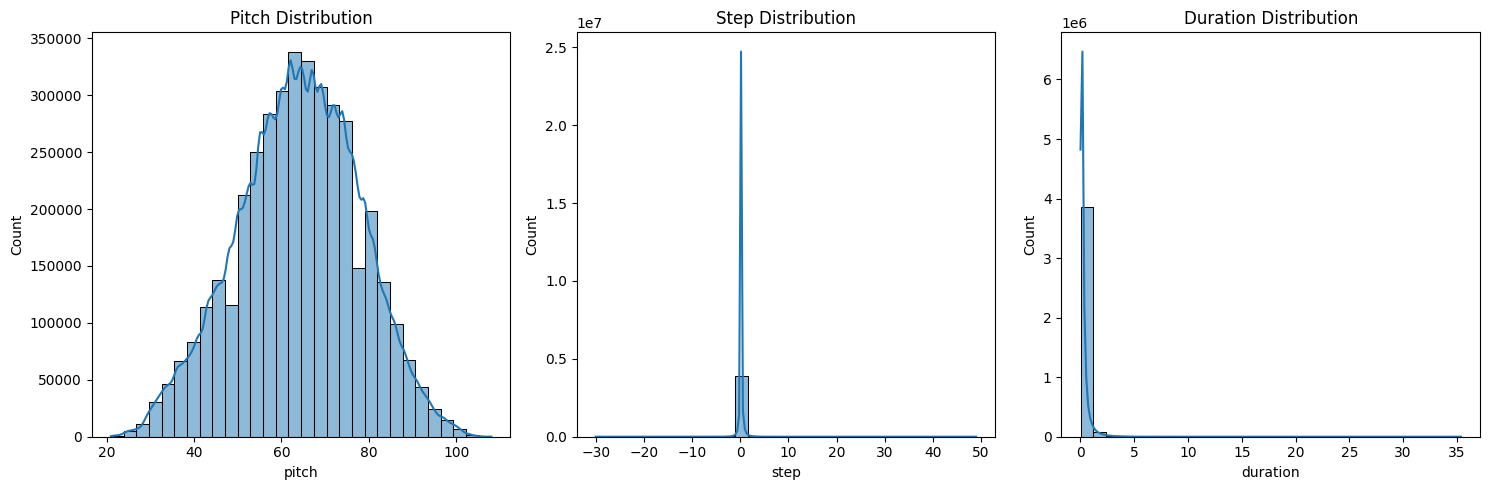

In [ ]:
# Plotting distributions of Pitch, Step, and Duration
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(all_notes['pitch'], kde=True, bins=30)
plt.title('Pitch Distribution')

plt.subplot(1, 3, 2)
sns.histplot(all_notes['step'], kde=True, bins=30)
plt.title('Step Distribution')

plt.subplot(1, 3, 3)
sns.histplot(all_notes['duration'], kde=True, bins=30)
plt.title('Duration Distribution')

plt.tight_layout()
plt.show()


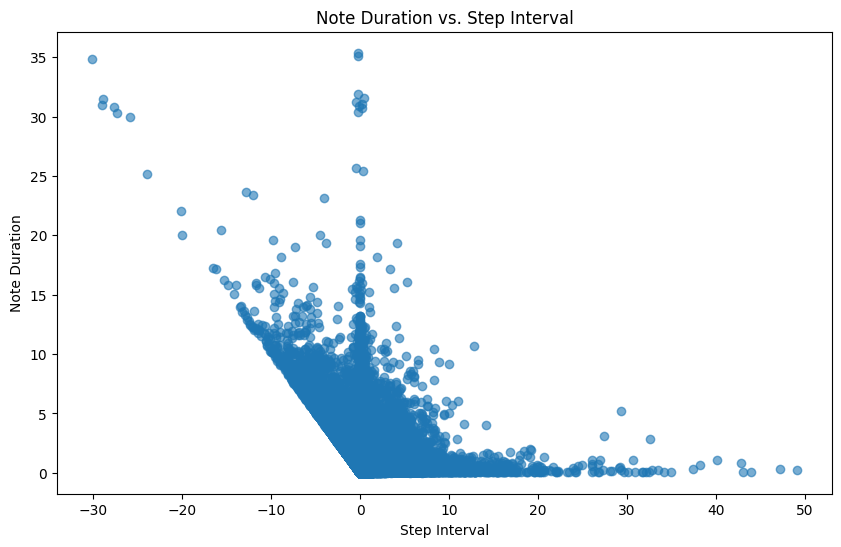

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(all_notes['step'], all_notes['duration'], alpha=0.6)
plt.title('Note Duration vs. Step Interval')
plt.xlabel('Step Interval')
plt.ylabel('Note Duration')
plt.show()


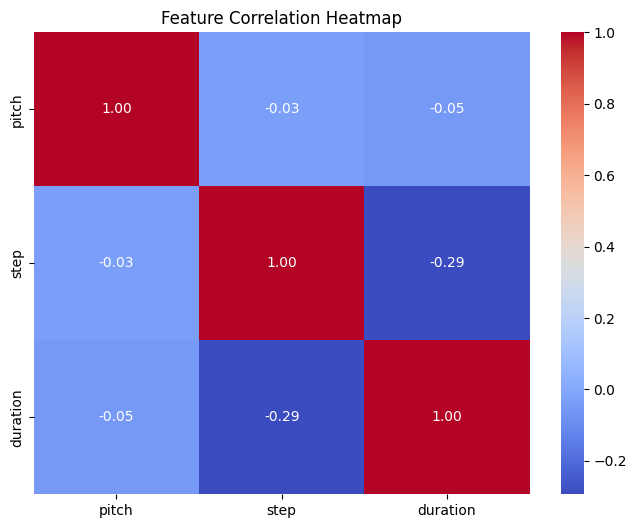

In [ ]:
# Calculate the correlation matrix
corr = all_notes[['pitch', 'step', 'duration']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


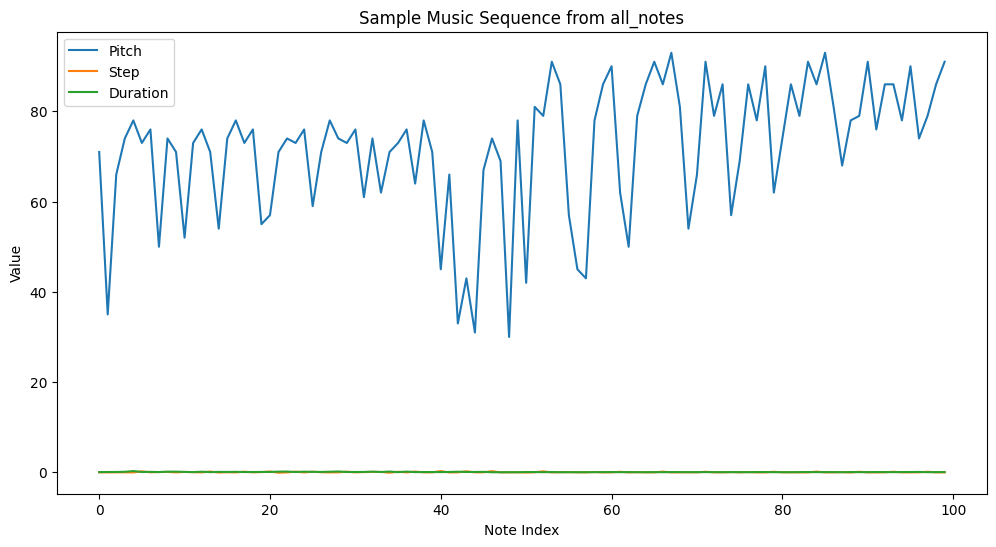

In [ ]:
def plot_generated_sequence(sequence, title='Generated Music Sequence'):
    plt.figure(figsize=(12, 6))
    plt.plot(sequence[:, 0], label='Pitch')
    plt.plot(sequence[:, 1], label='Step')
    plt.plot(sequence[:, 2], label='Duration')
    plt.title(title)
    plt.xlabel('Note Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming 'generated_sequence' is an array of generated notes with columns for pitch, step, and duration
plot_generated_sequence(sample_sequence_array, title='Sample Music Sequence from all_notes')



In [ ]:
!pip install tqdm


In [ ]:
from tqdm import tqdm

def create_sequences(dataframe, sequence_length=100):
    inputs = []
    targets = []

    # Use tqdm to show the progress bar
    for i in tqdm(range(0, len(dataframe) - sequence_length, 1), desc="Processing Notes"):
        input_sequence = dataframe.iloc[i:i + sequence_length].values
        # Assuming the target is the pitch of the next note
        target_sequence = dataframe.iloc[i + sequence_length].values[0]
        inputs.append(input_sequence)
        targets.append(target_sequence)
    return np.array(inputs), np.array(targets)
# The 'create_sequences' function processes a DataFrame containing musical note information,
# converting it into sequences of a specified length (default 100) for use in sequence prediction models.
# Each input sequence consists of 'sequence_length' consecutive notes, and the corresponding target is the pitch of the following note.
# This setup is common in tasks like music generation, where the goal is to predict the next note based on a sequence of previous notes.
# The function utilizes 'tqdm' to display a progress bar, providing visual feedback on the processing progress.
# The resulting input and target sequences are returned as NumPy arrays, ready for model training.

In [ ]:
inputs, targets = create_sequences(all_notes, sequence_length=100)
inputs, targets = create_sequences(all_notes, sequence_length=100)

# This line calls the 'create_sequences' function with the DataFrame 'all_notes', containing note data extracted from MIDI files,
# and a specified sequence length of 100 notes. The function processes the note data to generate sequences of 100 consecutive notes
# as inputs and the pitch of the next note following each sequence as the target. This results in two arrays: 'inputs', containing
# the input sequences for model training, and 'targets', containing the corresponding target pitches for each input sequence.
# These arrays are prepared for training a machine learning model that predicts the next note in a sequence, a common task in
# music generation and sequence modeling applications.


Processing Notes: 100%|██████████| 3944491/3944491 [11:20<00:00, 5799.18it/s]


In [ ]:
import numpy as np

# Save inputs
np.save('/content/drive/MyDrive/LSTM_Music/inputs.npy', inputs)
# Save inputs
np.save('/content/drive/MyDrive/LSTM_Music/targets.npy', targets)

# To load inputs later
#loaded_inputs = np.load('/content/drive/MyDrive/LSTM_Music/inputs.npy')
# To load inputs later
#loaded_inputs = np.load('/content/drive/MyDrive/LSTM_Music/inputs.npy')

# This block of code saves the 'inputs' and 'targets' arrays generated from the create_sequences function to disk
# using NumPy's save function. The files are stored in the specified directory within Google Drive, ensuring they
# are persistently stored outside the local environment. This is particularly useful for large datasets or when
# using environments like Google Colab, where session data can be ephemeral. By saving the data, you can efficiently
# resume your work without needing to reprocess the data. The commented lines at the end provide an example of how
# to reload the saved 'inputs' array from the drive, using NumPy's load function, for future use in model training
# or evaluation sessions.

In [ ]:
# Continue from the previously created 'inputs' and 'targets'
dataset_final = tf.data.Dataset.from_tensor_slices((inputs, targets))
dataset_final = dataset_final.shuffle(buffer_size=len(inputs)).batch(1024).prefetch(tf.data.experimental.AUTOTUNE)
# This block initializes a TensorFlow Dataset object from the 'inputs' and 'targets' arrays, facilitating efficient
# data handling and batching for training a machine learning model. The dataset is shuffled to ensure that the model
# does not learn anything from the order of the samples, which is essential for generalizing well to unseen data.
# It is then batched with a size of 1024, determining how many samples will be propagated through the network at once,
# balancing computational efficiency and training performance. Finally, 'prefetch' is used with 'AUTOTUNE' to allow
# TensorFlow to dynamically optimize the number of batches to prefetch, improving loading performance by ensuring that
# data is ready for the model as soon as it is needed. This setup is crucial for efficient training, particularly with
# large datasets and complex models.

In [ ]:
for inputs, targets in dataset_final.take(1):
    print(f"Input shape: {inputs.shape}")
    print(f"Target shape: {targets.shape}")
    print(f"Input dtype: {inputs.dtype}")
    print(f"Target dtype: {targets.dtype}")
# This code iterates through the first batch of the prepared TensorFlow dataset 'dataset_final' and prints the shapes
# and data types of the inputs and targets. This provides a quick sanity check to ensure that the dataset is correctly
# structured for training a neural network model. The input shape and target shape are crucial for configuring the model's
# input and output layers, while the data types indicate how the data should be processed by the model. Printing these
# details helps in debugging data processing pipelines and ensuring compatibility with the expected model architecture.

Input shape: (1024, 100, 3)
Target shape: (1024,)
Input dtype: <dtype: 'float64'>
Target dtype: <dtype: 'float64'>


In [ ]:
# To calculate dataset size
total_samples = len(inputs)   # Total samples present in inputs or targets
batch_size = 1024              # The batch size you set
total_batches = np.ceil(total_samples / batch_size)  # The total number of batches, ceiling to account for the last incomplete batch
# Display the calculated values
total_samples, batch_size, total_batches

(512, 512, 1.0)

In [ ]:

num_batches = 0
for _ in dataset_final:
    num_batches += 1

print(f"Total number of batches: {num_batches}")
# This code iterates through the entire 'dataset_final' to count the total number of batches. This is done by initializing
# a counter 'num_batches' to zero and incrementing it by one for each batch encountered in the dataset. After iterating
# through all the batches, it prints the total count. This information is useful for understanding the dataset's division
# into batches, which can impact model training dynamics, such as the number of iterations per epoch and the granularity
# of gradient updates. Knowing the total number of batches is also helpful for planning computational resources and
# training schedules, especially for very large datasets or when using hardware with limited memory.

Total number of batches: 3853


In [ ]:
from tensorflow.keras import mixed_precision

# Set the global policy to mixed_float16
mixed_precision.set_global_policy('mixed_float16')
# Verify the current policy
print(mixed_precision.global_policy())
# This code enables mixed precision training in TensorFlow by setting the global policy to 'mixed_float16'. Mixed precision
# training uses both 16-bit and 32-bit floating-point types during training, which can lead to significant performance
# improvements by reducing memory usage and speeding up training times, especially on GPUs that support float16 computations.
# After setting the policy, it verifies the current policy by printing it out. This confirmation is crucial to ensure that
# the policy was successfully applied, as mixed precision training has specific hardware requirements and may not be
# supported on all devices. By using mixed precision, models can potentially train faster and with less memory without
# significant loss in accuracy.

<Policy "mixed_float16">


In [ ]:
# Shuffle the dataset
shuffled_dataset = dataset_final.shuffle(buffer_size=  3853)

# Take half of the dataset
final_dataset_v2 = shuffled_dataset.take(1500)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf

def build_music_model(input_shape, output_units, num_units=64, num_layers=2, l2_reg=1e-4):
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Only the last layer should not return sequences
        if i == 0:
            model.add(LSTM(num_units, return_sequences=return_sequences, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), input_shape=input_shape))
        else:
            model.add(LSTM(num_units, return_sequences=return_sequences, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(output_units, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model

# Assuming 'inputs' is defined and contains your processed data
input_shape = (inputs.shape[1], inputs.shape[2])  # Example: (100, 3)

output_units = 128  # Example: Number of unique notes/pitches

lr_callback = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 10 else lr, verbose=1)

model = build_music_model(input_shape=input_shape, output_units=output_units, num_units=64, num_layers=2)
model.summary()
# This block of code defines and builds a LSTM-based sequential neural network model tailored for music data.
# The model consists of multiple LSTM layers followed by Batch Normalization and Dropout for regularization to prevent overfitting.
# The final layers are Dense layers, with the last one using a softmax activation function suitable for classification tasks.
# The model is compiled with the Adam optimizer and sparse categorical crossentropy loss, which is commonly used for multi-class classification problems.
# The LearningRateScheduler callback is prepared to adjust the learning rate as training progresses, potentially improving training effectiveness.
# The 'build_music_model' function encapsulates this architecture, allowing for easy customization of the model's depth, regularization, and other parameters.
# The final line prints a summary of the model, providing insight into the model's architecture, including the number of parameters and the shape of the output at each layer.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           17408     
                                                                 
 batch_normalization (Batch  (None, 100, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

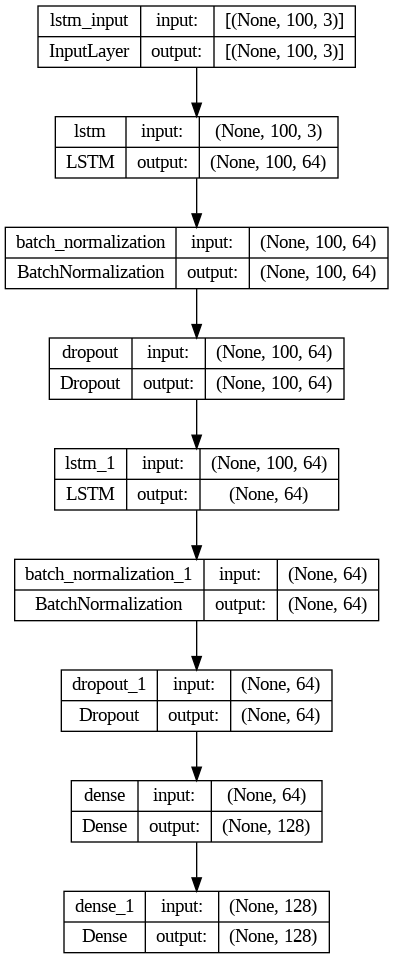

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)


In [ ]:
# Enable eager execution for debugging
tf.config.run_functions_eagerly(True)

In [ ]:
# Setup ModelCheckpoint to save the model weights during training
checkpoint_path = "/content/drive/MyDrive/LSTM_Music/check_points/cp-{epoch:04d}.ckpt"
cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, period=1)

# Train the model
history = model.fit(final_dataset_v2, epochs=100, callbacks=[cp_callback], verbose=1)

# Disable eager execution for normal TensorFlow operation after debugging
tf.config.run_functions_eagerly(False)

Epoch 1/100


In [ ]:
# Directory where the checkpoints are saved
checkpoint_dir = "/content/Training_CheckPoints_Final/"

# Checkpoint prefix - use the part of the filename before '.data-...'
checkpoint_prefix = "cp-0039.ckpt"

# Construct the full path to the checkpoint (without the '.data-...', '.index', and '.meta' extensions)
checkpoint_path = checkpoint_dir + checkpoint_prefix

# Load the weights into your model
model.load_weights(checkpoint_path)


In [ ]:
# Optionally, you can define new callbacks, such as a new ModelCheckpoint
new_checkpoint_path = "/content/drive/MyDrive/LSTM_Music/check_points/cp-{epoch:04d}.ckpt"
new_cp_callback = ModelCheckpoint(new_checkpoint_path, verbose=1, save_weights_only=True, period=1)

# Train the model with the new dataset and batch size
new_history = model.fit(final_dataset_v2, epochs=50, callbacks=[new_cp_callback], verbose=1)


Epoch 1/50
1500/1500 [==============================] - ETA: 0s - loss: 3.4099 - sparse_categorical_accuracy: 0.1183
Epoch 1: saving model to /content/drive/MyDrive/LSTM_Music/check_points/cp-0001.ckpt
1500/1500 [==============================] - 198s 110ms/step - loss: 3.4099 - sparse_categorical_accuracy: 0.1183
Epoch 2/50
1500/1500 [==============================] - ETA: 0s - loss: 3.4059 - sparse_categorical_accuracy: 0.1190
Epoch 2: saving model to /content/drive/MyDrive/LSTM_Music/check_points/cp-0002.ckpt
1500/1500 [==============================] - 194s 110ms/step - loss: 3.4059 - sparse_categorical_accuracy: 0.1190
Epoch 3/50
1500/1500 [==============================] - ETA: 0s - loss: 3.4038 - sparse_categorical_accuracy: 0.1199
Epoch 3: saving model to /content/drive/MyDrive/LSTM_Music/check_points/cp-0003.ckpt
1500/1500 [==============================] - 190s 111ms/step - loss: 3.4038 - sparse_categorical_accuracy: 0.1199
Epoch 4/50
1500/1500 [==============================

In [ ]:
import json

# Convert the history.history dict to a JSON file
with open('/content/drive/MyDrive/LSTM_Music/training_history.json', 'w') as f:
    json.dump(new_history.history, f)

# Later on, to load the history:
#with open('/content/drive/MyDrive/LSTM_Music/training_history.json', 'r') as f:
   # loaded_history = json.load(f)


In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/LSTM_Music/saved_model/my_model')

# To load the model back:
# model = tf.keras.models.load_model('saved_model/my_model')


In [ ]:
# Save only the weights
model.save_weights('/content/drive/MyDrive/LSTM_Music/model_weights.h5')

# To load the weights later, first build the model and then call load_weights
#model.load_weights('/content/drive/MyDrive/LSTM_Music/model_weights.h5')


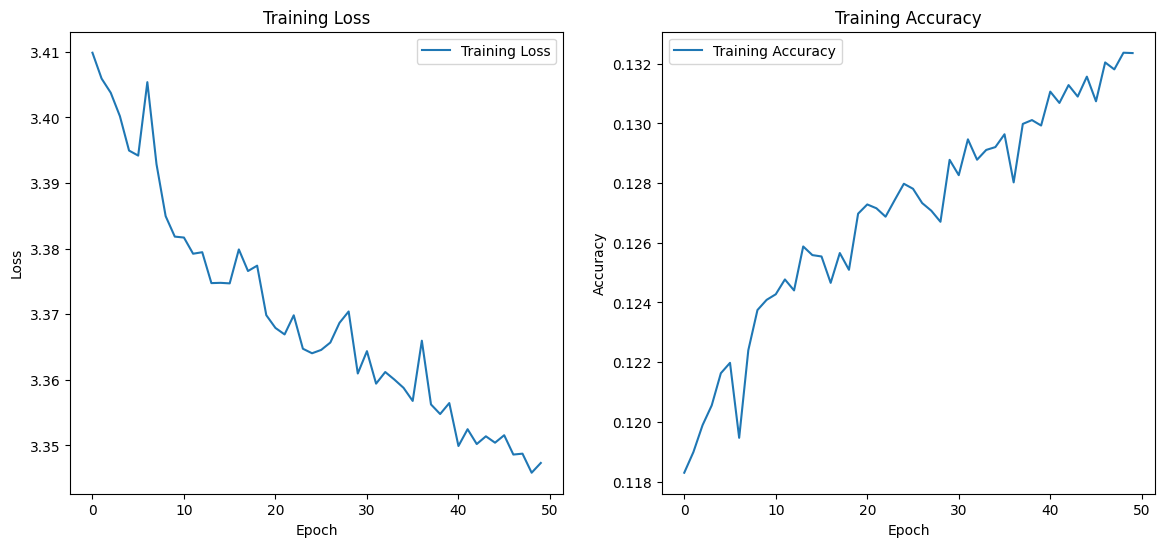

In [ ]:
plt.figure(figsize=(14, 6))

# Plot training loss using 'new_history'
plt.subplot(1, 2, 1)
plt.plot(new_history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy using 'new_history'
plt.subplot(1, 2, 2)
plt.plot(new_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


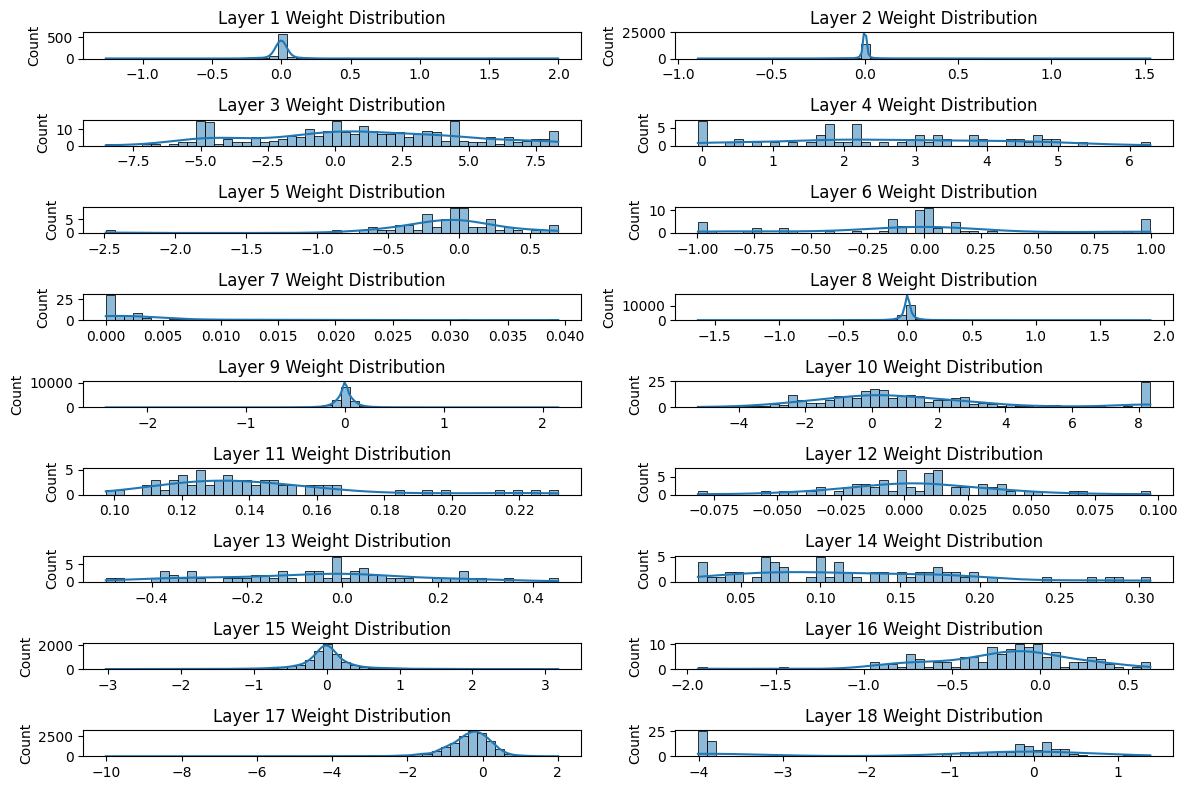

In [ ]:
weights = model.get_weights()
plt.figure(figsize=(12, 8))
for i, weight_matrix in enumerate(weights):
    plt.subplot(len(weights)//2, 2, i+1)
    sns.histplot(weight_matrix.flatten(), kde=True, bins=50)
    plt.title(f'Layer {i+1} Weight Distribution')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(7, 5))
if 'lr' in new_history.history:
    plt.plot(new_history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()
else:
    print("Learning rate history not found in 'new_history'.")


Learning rate history not found in 'new_history'.


<Figure size 700x500 with 0 Axes>

##DEMO

In [3]:
# Install FluidSynth: a real-time software synthesizer based on the SoundFont 2 specifications.
# It's used to convert MIDI data into audio that can be played or further processed.
# The '-y' option automatically agrees to the installation, avoiding the need for manual confirmation.
!sudo apt install -y fluidsynth
# Upgrade and install pyfluidsynth: a Python binding for FluidSynth, enabling Python scripts to interact with the FluidSynth library.
# This allows for synthesizing audio from MIDI data directly within Python, suitable for dynamic music generation and manipulation tasks.
!pip install --upgrade pyfluidsynth
# Install pretty_midi: a Python library for analyzing and editing MIDI files.
# It provides simple and intuitive functions to work with MIDI data, making it ideal for tasks like music information retrieval, composition, and data-driven music analysis.
!pip install pretty_midi


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
import collections  # Provides specialized container datatypes, such as defaultdict and OrderedDict, which offer additional functionality compared to Python's built-in containers like dict, list, set, and tuple.

import fluidsynth  # Allows for real-time synthesis of MIDI data into audio using the FluidSynth software synthesizer, enabling audio generation and manipulation within Python.

import glob  # Helps with file path pattern matching, allowing for searching and listing files in a directory that match a specified pattern, useful for batch processing files.

import numpy as np  # A fundamental package for scientific computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

import pathlib  # Offers object-oriented filesystem paths, providing a simple way to interact with file system paths, making file manipulation tasks more intuitive and portable across operating systems.

import pandas as pd  # A powerful data manipulation and analysis library, providing data structures like DataFrame and Series for handling and analyzing structured data.

import pretty_midi  # A library for analyzing and manipulating MIDI files, enabling tasks such as parsing MIDI files, extracting musical information, and creating new MIDI files programmatically.

import seaborn as sns  # A statistical data visualization library based on matplotlib, providing a high-level interface for drawing attractive and informative statistical graphics.

import tensorflow as tf  # An end-to-end open-source machine learning platform, widely used for building and training neural networks for deep learning tasks.

from matplotlib import pyplot as plt  # A plotting library and its object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK.

from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense  # Keras layers used for building neural network models: Input for specifying the shape/dimensions of the input data, Bidirectional for wrapping RNN layers (e.g., LSTM) to make them bidirectional, LSTM for Long Short-Term Memory layers, and Dense for fully connected neural network layers.

from tensorflow.keras.models import Model  # The basic class in Keras for constructing neural network models, providing functionality to build and train models.

from IPython import display  # Provides display tools for IPython environments (like Jupyter notebooks), enabling rich media representations of objects (e.g., displaying images or videos within the notebook).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
seed_sequence = np.load('/content/drive/MyDrive/LSTM_Music/inputs.npy')[0][:100]  # Take the first 50 notes of the first sequence
# This line loads the 'inputs' array from a stored .npy file, specifically the one saved previously in the Google Drive
# directory '/content/drive/MyDrive/LSTM_Music/'. It then selects the first sequence in the array and slices the first 100 notes
# from it to create a 'seed_sequence'. This seed sequence is typically used as a starting point for generating new music
# sequences by feeding it into a trained model, which then predicts subsequent notes. This approach is common in music
# generation tasks where the initial notes set the tone or theme for the generated piece, and the model continues the sequence
# in a stylistically consistent manner based on its training.

In [6]:
# Load your trained model
model_path = '/content/drive/MyDrive/LSTM_Music/saved_model/my_model'
model = tf.keras.models.load_model(model_path)
# This code loads a pre-trained TensorFlow/Keras model from the specified directory. The 'model_path' points to the location
# where the model has been saved, typically after training has been completed. This functionality is crucial for deploying
# machine learning models into production or for continuing model evaluation and testing without the need to retrain from
# scratch. Loading a model in this way restores the model's architecture, weights, and training configuration, enabling
# immediate use for predictions or further training.

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [10]:
def predict_next_note(model, current_sequence, temperature=1.0):
    # Predict the next note
    prediction = model.predict(np.expand_dims(current_sequence, axis=0))  # Add batch dimension

    # Apply temperature to the predictions
    prediction = prediction / temperature

    # Sample the next note from the prediction
    next_note = np.random.choice(range(prediction.shape[-1]), p=prediction.ravel())

    return next_note
# Generate music
generated_sequence = []
current_sequence = seed_sequence.copy()

for _ in range(500):  # Generate 500 notes
    new_note = predict_next_note(model, current_sequence, temperature=2.0)

    # Append the new note to the generated sequence
    generated_sequence.append(new_note)

    # Update current_sequence
    current_sequence = np.roll(current_sequence, -1, axis=0)  # Shift everything one step to the left
    current_sequence[-1] = new_note  # Replace the last note with the new note
# The 'predict_next_note' function takes a trained model and a current sequence of notes as input and predicts the next note
# in the sequence. It employs a 'temperature' parameter to control the randomness of predictions, with a higher temperature
# leading to more random outputs. The function expands the input sequence's dimensions to add a batch dimension required by
# the model, makes a prediction, applies temperature scaling, and samples a new note based on the scaled prediction probabilities.

# Following this, the loop generates a sequence of 500 notes by iteratively predicting the next note based on the current
# sequence, appending the new note to the generated sequence, and updating the current sequence by shifting it one step to
# the left and inserting the new note at the end. This process simulates the sequential generation of music, where each new
# note is influenced by the preceding notes in the sequence, thereby creating a coherent and evolving musical piece.

1/1 [==============================] - 0s 80ms/step


In [12]:
import pretty_midi
import IPython.display as ipd

def notes_to_midi(pitches, output_file='generated_music.mid', velocity=100, step=0.45, duration=0.42):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # 0 = Acoustic Grand Piano

    start_time = 0
    for pitch in pitches:
        # Assuming pitch is a single integer value for each note
        end_time = start_time + duration
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=pitch,
            start=start_time,
            end=end_time
        )
        instrument.notes.append(note)
        start_time += step  # Increment start time for the next note

    pm.instruments.append(instrument)
    pm.write(output_file)

# Convert generated pitches to MIDI
notes_to_midi(generated_sequence)

# Function to play the generated MIDI file
def play_midi_file(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    audio_data = midi_data.synthesize()
    return ipd.Audio(audio_data, rate=44100)

# Play the generated MIDI file
ipd.display(play_midi_file('generated_music.mid'))
# The 'notes_to_midi' function converts a sequence of pitch values ('pitches') into a MIDI file. For each pitch in the sequence,
# it creates a MIDI note with the specified velocity (loudness), duration, and time step between consecutive notes. These notes
# are added to a MIDI instrument track, which is then saved to a MIDI file ('generated_music.mid'). This file represents the
# generated music piece in a standard format that can be played by most media players or imported into music production software.

# After generating the MIDI file, the 'play_midi_file' function uses 'pretty_midi' to read the MIDI file and synthesize it into
# audio data. This audio data is then played directly in the IPython environment using 'IPython.display.Audio', allowing immediate
# listening and evaluation of the generated music piece. This interactive feedback is valuable for experimenting with and refining
# the music generation process.

Output hidden; open in https://colab.research.google.com to view.